In [22]:
import os, sys
from tqdm import trange

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn
from torch.utils.data import TensorDataset

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
from data_analysis.visualization.publication import pub_show
from utils.containers import partition
from simulate import rep_sim

from model import MLP

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

# device = torch.device("cpu")

GPU available


In [23]:
## Load data
data_path = "../DNN/data/"

properties = pd.read_csv(
    data_path + "amazing data/properties simple.txt", sep=" ", header=0
)
# properties = pd.read_csv(
#     data_path + "Rogers McClelland/Table B1.txt", sep=" ", header=0
# )

names = properties.columns.to_numpy()

outputs = properties.to_numpy().T
inputs = np.eye(len(names))

# encoding = Encoding(dict(zip(names, inputs)))
encoding = OneHot(names)

outputs = torch.from_numpy(outputs.astype(np.float32)).to(device)
inputs = torch.from_numpy(inputs.astype(np.float32)).to(device)

dataset = TensorDataset(inputs, outputs)
train_datasets = [dataset]
val_dataset = [dataset]

tracked_datasets = val_dataset + train_datasets

In [24]:
gain = 1
# gain = 2
P = 20
L = 10

In [25]:
## Instantiate model
model = MLP(
    encoding=encoding,
    input_size=inputs.shape[1],
    output_size=outputs.shape[1],
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
)

In [26]:
## Setup compiler

# Define hyperparameters
lr = 0.01 / P

# Define Loss, Optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model, lambda inputs: model(inputs)[1][int(len(model) / 2)]
    ),
    "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
}

In [27]:
## Get all activations before training
activations_0 = []

for layer in range(len(model) - 1):
    act = get_activations(val_dataset, lambda inputs: model(inputs)[1][layer], encoding)
    activations_0.append(act)

index_names = activations_0[0].index.names
activations_0 = pd.concat(activations_0, keys=list(range(len(activations_0))))
activations_0.index = activations_0.index.set_names(["Layer"] + index_names)

In [28]:
## Training run
compiler.training_run(train_datasets, tracked_datasets, n_epochs=50000, batch_size=100)

Training:  59%|█████▉    | 29393/50000 [08:26<05:55, 58.03steps/s, train_loss=0.00002, val_loss=0.00002]


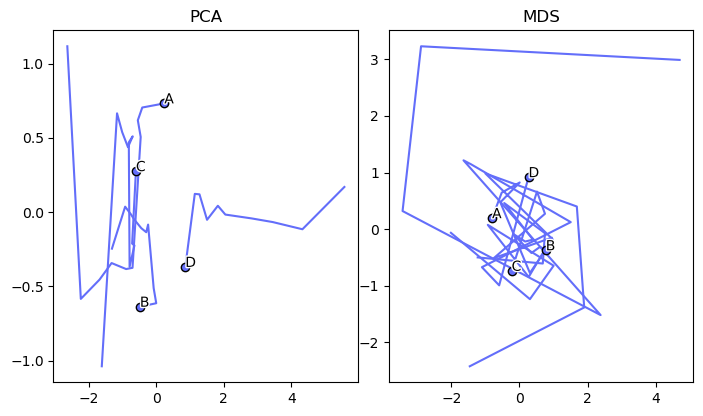

interactive(children=(SelectionSlider(description='Layer:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), …

In [29]:
## Get all activations
activations = []

for layer in range(len(model) - 1):
    act = get_activations(val_dataset, lambda inputs: model(inputs)[1][layer], encoding)
    activations.append(act)

index_names = activations[0].index.names
activations = pd.concat(activations, keys=list(range(len(activations))))
activations.index = activations.index.set_names(["Epoch"] + index_names)

animation = SliderAnimation(
    {
        "PCA": ActivationsAnimation(
            activations, transform="PCA_per_epoch", plot_labels=True
        ),
        "MDS": ActivationsAnimation(
            activations, transform="MDS_per_epoch", plot_labels=True
        ),
    },
    parameters=list(set(activations.index.get_level_values("Epoch"))),
    parameter_name="Layer",
    fig_size=4,
)

activations.index = activations.index.set_names(["Layer"] + index_names)

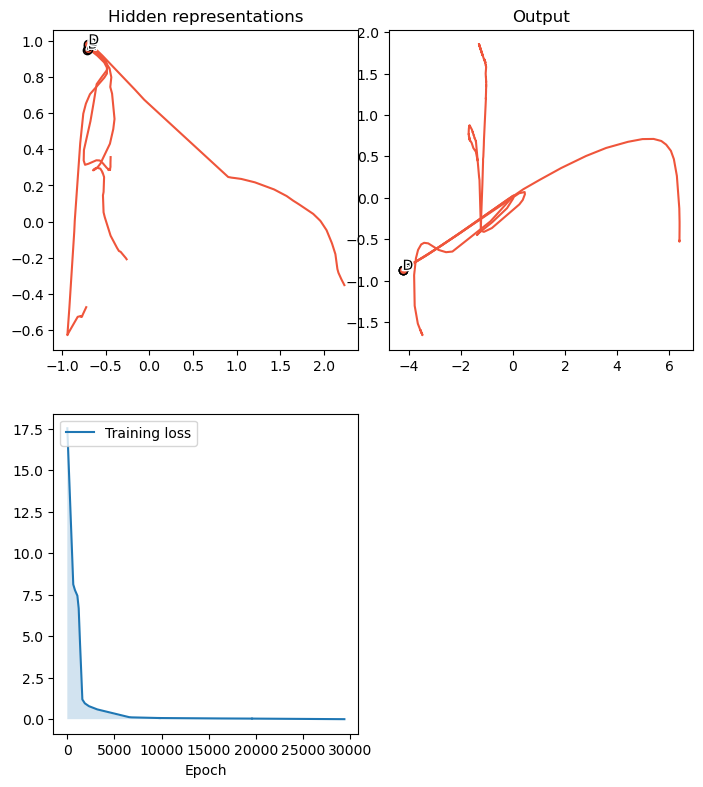

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 10…

In [30]:
## Visualize representation dynamics
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "Epoch % 10 == 0"
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()

epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()

animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(
            data_hid.query("Dataset != 0"), transform="PCA", plot_labels=True
        ),
        "Output": ActivationsAnimation(
            data_output.query("Dataset != 0"),
            transform="PCA",
            plot_labels=True,
        ),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                # "Validation loss": val_loss,
            },
            unitless_graphs={},
            # x_bounds=(0, 800),
            # y_bounds=(0, 1),
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

In [31]:
## Plot reduction
# x = data_hid_early.query("Epoch == 0 and Dataset == 0").to_numpy()
x = inputs.cpu()
y = data_output.query("Epoch == 0 and Dataset == 0").to_numpy()
D2 = 0
for i, j in zip(x, y):
    D2 += ((np.linalg.norm(j) / np.linalg.norm(i)) ** 2) / x.shape[0]
print(f"D0^2: {D2}")

output_dist2 = 2

m = np.linspace(0, 1, L)

base = np.exp((np.log(D2)) * m)

D0^2: 2.9869390829427667e-05


In [ ]:
def dist2(act1: pd.DataFrame, act2: pd.DataFrame):
    distances = []
    for (epoch, data1_epoch), (epoch, data2_epoch) in zip(
        act1.groupby("Layer"), act2.groupby("Layer")
    ):
        distance = 0
        if act1 is act2:
            n = len(data1_epoch) * len(data2_epoch) - 1
        else:
            n = len(data1_epoch) * len(data2_epoch)
        for input_1, act_1 in data1_epoch.groupby("Input"):
            for input_2, act_2 in data2_epoch.groupby("Input"):
                distance += np.linalg.norm(act_1.to_numpy() - act_2.to_numpy()) / n
        distances.append(distance)
    distances2 = np.array([dist**2 for dist in distances])

    return distances2

In [ ]:
# plant = ["pine", "oak", "rose", "daisy"]
# animal = ["robin", "canary", "sunfish", "salmon"]
# tree = ["pine", "oak"]
# flower = ["daisy", "rose"]
# bird = ["robin", "canary"]
# fish = ["sunfish", "salmon"]
# oak = ["oak"]
# pine = ["pine"]
# daisy = ["daisy"]
# rose = ["rose"]
# robin = ["robin"]
# canary = ["canary"]
# sunfish = ["sunfish"]
# salmon = ["salmon"]


# features = {
#     "plant/animal": [plant, animal],
#     "tree/flower": [tree, flower],
#     "bird/fish": [bird, fish],
#     "oak/pine": [oak, pine],
#     "daisy/rose": [daisy, rose],
#     "robin/canary": [robin, canary],
#     "sunfish/salmon": [sunfish, salmon],
# }

In [ ]:
## Starting features
labels = set(names)
par = partition(labels, n=2)
par = [p for p in par if (len(p[0]) != 0 and len(p[1]) != 0)]
features = {
    "(" + ",".join(list(p[0])) + ")/(" + ",".join(list(p[1])) + ")": list(map(list, p))
    for p in par
}

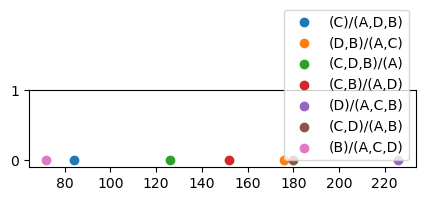

'(D)/(A,C,B)'

In [ ]:
## Theory
R = L

from itertools import cycle

x = np.arange(L)
output_pd = pd.DataFrame(outputs.cpu(), names)

fig = plt.figure(figsize=(5, 1))

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = cycle(prop_cycle.by_key()["color"])
count = {}
dist2_ys = {}
for name, feature in features.items():
    # dist2_y = (output_pd.loc[feature[0]] @ output_pd.loc[feature[1]].T).to_numpy().sum()
    dist2_y = np.sum(
        [
            np.linalg.norm(y_1[1] - y_2[1]) ** 2
            for y_1 in output_pd.loc[feature[0]].iterrows()
            for y_2 in output_pd.loc[feature[1]].iterrows()
        ]
    )
    dist2_ys[name] = dist2_y
    # plt.axvline(1 / (1 + dist2_y / R), label=name, color=next(colors))
    # plt.plot(x, np.log(x / (L - x) * dist2_y), label=name, color=next(colors))
    try:
        count[dist2_y] += 1
    except KeyError:
        count[dist2_y] = 0
    plt.scatter(dist2_y, count[dist2_y] / 7, label=name)

# plt.xlim(-1, 10)
plt.ylim(-0.1, 1)
plt.legend(loc="lower right")
plt.show()

max_feature = max(dist2_ys, key=dist2_ys.get)
max_feature

/tmp/ipykernel_16962/423602055.py:13: RuntimeWarning: invalid value encountered in divide
  distance += np.linalg.norm(act_1.to_numpy() - act_2.to_numpy()) / n
/tmp/ipykernel_16962/423602055.py:13: RuntimeWarning: invalid value encountered in divide
  distance += np.linalg.norm(act_1.to_numpy() - act_2.to_numpy()) / n
/tmp/ipykernel_16962/423602055.py:13: RuntimeWarning: invalid value encountered in divide
  distance += np.linalg.norm(act_1.to_numpy() - act_2.to_numpy()) / n
/tmp/ipykernel_16962/423602055.py:13: RuntimeWarning: invalid value encountered in divide
  distance += np.linalg.norm(act_1.to_numpy() - act_2.to_numpy()) / n
/tmp/ipykernel_16962/423602055.py:13: RuntimeWarning: invalid value encountered in divide
  distance += np.linalg.norm(act_1.to_numpy() - act_2.to_numpy()) / n
/tmp/ipykernel_16962/423602055.py:13: RuntimeWarning: invalid value encountered in divide
  distance += np.linalg.norm(act_1.to_numpy() - act_2.to_numpy()) / n
/tmp/ipykernel_16962/423602055.py:13: Ru

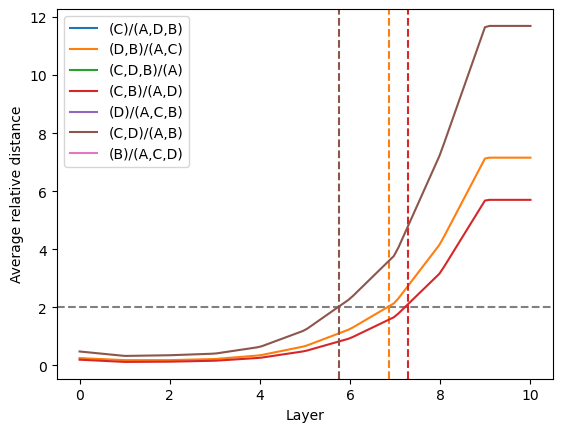

In [ ]:
## Experiment

cutoff = 2
x = np.linspace(0, L, 100)
xp = np.arange(0, L)

plt.axhline(y=cutoff, color="gray", linestyle="--")
cross_points = {}
for name, feature in features.items():
    h_1 = activations.loc[:, :, feature[0]]
    h_2 = activations.loc[:, :, feature[1]]
    dist2_h = dist2(h_1, h_2)
    norm = np.average((dist2(h_1, h_1), dist2(h_2, h_2)))
    # norm_1 = np.average(np.sum(h_1**2, axis=1))
    # norm_2 = np.average(np.sum(h_2**2, axis=1))
    # norm = np.average((norm_1, norm_2))

    rel_dist = dist2_h / norm
    fit = np.interp(x, xp, rel_dist)
    p = plt.plot(x, fit, label=name)
    color = p[0].get_color()
    try:
        first_cross = np.where(fit > cutoff)[0][0]
        plt.axvline(x[first_cross], color=color, linestyle="--")
        cross_points[name] = first_cross
    except IndexError:
        pass


# plt.xlim(0,2)
# plt.ylim(0, 1)
plt.xlabel("Layer")
plt.ylabel("Average relative distance")
plt.legend()
plt.show()

# max_feature = min(cross_points, key=cross_points.get)
# max_feature

In [ ]:
new_par = []
for subset in features[max_feature]:
    new_par += partition(set(subset), n=2)
new_par = [p for p in new_par if (len(p[0]) != 0 and len(p[1]) != 0)]
new_features = {
    "(" + ",".join(list(p[0])) + ")/(" + ",".join(list(p[1])) + ")": list(map(list, p))
    for p in new_par
}
print(new_features)
features = new_features

{'(pine)/(oak,rose,daisy)': [['pine'], ['oak', 'rose', 'daisy']], '(rose,daisy)/(oak,pine)': [['rose', 'daisy'], ['oak', 'pine']], '(pine,rose,daisy)/(oak)': [['pine', 'rose', 'daisy'], ['oak']], '(pine,rose)/(oak,daisy)': [['pine', 'rose'], ['oak', 'daisy']], '(daisy)/(oak,pine,rose)': [['daisy'], ['oak', 'pine', 'rose']], '(pine,daisy)/(oak,rose)': [['pine', 'daisy'], ['oak', 'rose']], '(rose)/(oak,pine,daisy)': [['rose'], ['oak', 'pine', 'daisy']], '(canary)/(salmon,sunfish,robin)': [['canary'], ['salmon', 'sunfish', 'robin']], '(sunfish,robin)/(salmon,canary)': [['sunfish', 'robin'], ['salmon', 'canary']], '(sunfish,robin,canary)/(salmon)': [['sunfish', 'robin', 'canary'], ['salmon']], '(canary,robin)/(salmon,sunfish)': [['canary', 'robin'], ['salmon', 'sunfish']], '(sunfish)/(salmon,canary,robin)': [['sunfish'], ['salmon', 'canary', 'robin']], '(sunfish,canary)/(salmon,robin)': [['sunfish', 'canary'], ['salmon', 'robin']], '(robin)/(salmon,sunfish,canary)': [['robin'], ['salmon', 

In [ ]:
## Def function taking in partition giving features

In [ ]:
## Simulation

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = cycle(prop_cycle.by_key()["color"])
for name, feature in features.items():
    h0 = (
        (
            activations_0.loc[:, :, feature[0]].query(f"Layer=={int(L/2)}")
            @ activations_0.loc[:, :, feature[1]].query(f"Layer=={int(L/2)}").T
        )
        .to_numpy()
        .sum()
    )
    y0 = (
        (
            activations_0.loc[:, :, feature[0]].query("Layer==0")
            @ activations_0.loc[:, :, feature[1]].query("Layer==0").T
        )
        .to_numpy()
        .sum()
    )
    D0 = y0 / h0
    dist2_y = (output_pd.loc[feature[0]] @ output_pd.loc[feature[1]].T).to_numpy().sum()
    h = rep_sim(h0, y0, y0, dist2_y)
    plt.axvline(h / h0, label=name, color=next(colors))
    # plt.axvline(D0, label=name, color=next(colors))
plt.xlim(0.9, 1)
# plt.ylim(0, 10)
plt.legend()
plt.show()

KeyboardInterrupt: 

/tmp/ipykernel_5418/4058951432.py:11: RuntimeWarning: invalid value encountered in divide
  pred = np.exp(-kernel(y_0) / kernel(h_0))
/tmp/ipykernel_5418/4058951432.py:16: RuntimeWarning: invalid value encountered in divide
  plt.imshow(kernel(h) / kernel(h_0))


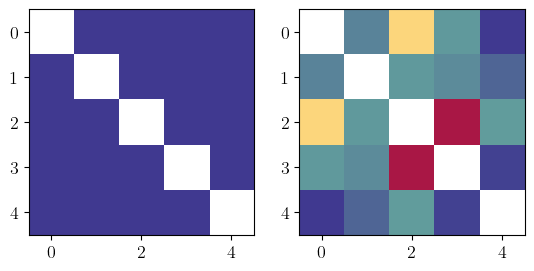

In [ ]:
h = activations.query(f"Layer=={int(L/2)}").to_numpy()
h_0 = activations_0.query(f"Layer=={int(L/2)}").to_numpy()
y_0 = activations_0.query(f"Layer=={L-1}").to_numpy()

def kernel(h):
    kernel = np.array([[np.sum((h_1 - h_2) ** 2) for h_1 in h] for h_2 in h])
    return kernel


plt.subplot(1, 2, 1)
pred = np.exp(-kernel(y_0) / kernel(h_0))
# np.fill_diagonal(pred, 1)
plt.imshow(pred)

plt.subplot(1, 2, 2)
plt.imshow(kernel(h) / kernel(h_0))
plt.show()

/tmp/ipykernel_5418/2576756654.py:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(h @ h.T))


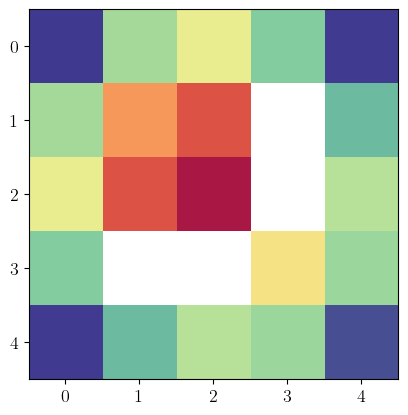

In [ ]:
h = activations.query(f"Layer=={2}").to_numpy()
plt.imshow(np.log(h @ h.T))
plt.show()

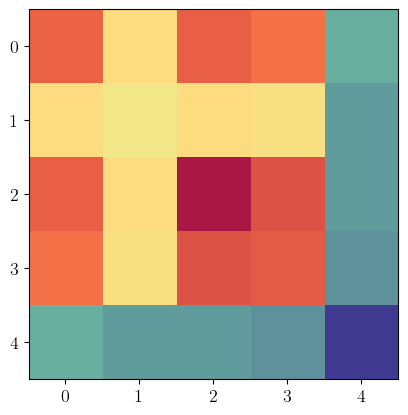

In [ ]:
plt.imshow((h_0 @ h_0.T) * np.exp(-(y_0 @ y_0.T) / (h_0 @ h_0.T)))
plt.show()

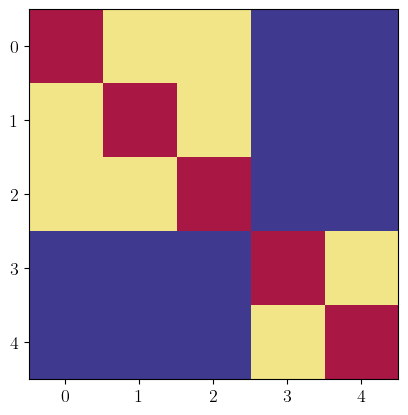

In [ ]:
plt.imshow(output_pd @ output_pd.T)
plt.show()

(array([ 5, 15, 25, 35]),
 [Text(5, 0, 'D'), Text(15, 0, 'A'), Text(25, 0, 'B'), Text(35, 0, 'C')])

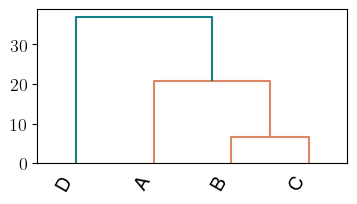

In [ ]:
# Plot dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

h = activations.query(f"Layer=={5}").to_numpy()
names = activations.loc[0].index.get_level_values("Input").to_numpy()

X = scipy.cluster.hierarchy.weighted(h)
Z = linkage(X, "ward")
fig = plt.figure(figsize=(4, 2))

dn = dendrogram(Z)
ax = plt.gca()
ax.set_xticklabels(
    [names[leave] for leave in dn["leaves"]], rotation="vertical", fontsize=14
)
plt.xticks(rotation=60, ha="right")

Computing automata: 100%|██████████| 10/10 [00:00<00:00, 731.35it/s]


IndexError: list index out of range

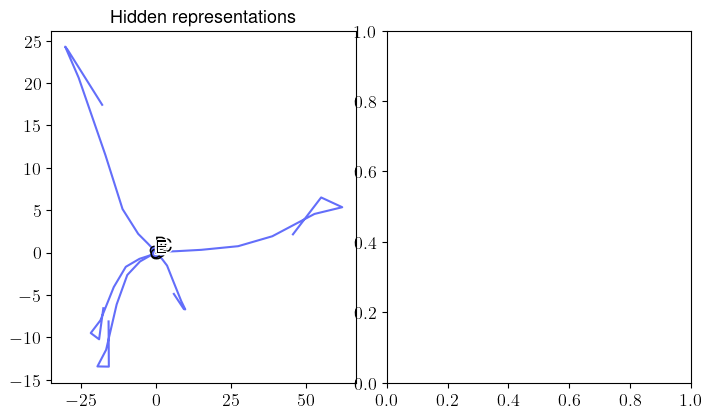

In [ ]:
## Visualize automaton dynamics
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import ActivationsAnimation
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation

a = activations
a.index = a.index.rename(["Epoch", "Dataset", "Input"])

automaton_history = to_automaton_history(a, 0 * a, 0.1)
n_states = np.array([len(automaton.states) for automaton in automaton_history])


animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(a, transform="PCA_per_epoch"),
        # "Output": ActivationsAnimation(
        #     data_output, transform="none", fixed_points=encoding.encoding
        # ),
        "Automaton": AutomatonAnimation(automaton_history),
    },
    parameters=list(set(a.index.get_level_values("Epoch"))),
    parameter_name="Epoch",
    fig_size=4,
)


# TODO Plot map A(h)
# TODO Plot pairwise distances
# TODO Plot total theta

In [ ]:
std = float(np.linalg.norm(a.std()))
automaton_history = to_automaton_history(a, 0 * a, 0.1 * std)
[x for x in automaton_history.states]